Analysis Objectives

To analyze patterns and trends in citizen feedback across different government services and agencies.

To assess the overall levels of satisfaction expressed by citizens in response to service resolutions.

To determine the sentiment polarity of textual feedback to understand the emotional tone behind citizen responses.

In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
import pandas as pd
d=pd.read_csv(r"C:\Users\USER\Downloads\311_Resolution_Satisfaction_Survey.csv")
d.head(10)

,Unique Key,Agency Acronym,Agency Name,Complaint Type,Descriptor,Borough,Resolution Description,Survey Year,Survey Month,Satisfaction Response,Dissatisfaction Reason
0,16657800-00015172,DOB,Department of Buildings,Adult Establishment,Zoning Violation,MANHATTAN,The Department of Buildings investigated this ...,2022,10,Strongly Agree,NaN
1,58524985-00281320,DOB,Department of Buildings,Adult Establishment,Zoning Violation,BROOKLYN,The Department of Buildings investigated this ...,2024,11,Strongly Disagree,The Agency did not correct the issue.
2,75073480-00178242,DFTA,Department for the Aging,Legal Services Provider Complaint,NaN,MANHATTAN,The Department for the Aging contacted you and...,2024,3,Strongly Agree,NaN
3,46435198-00170848,DOB,Department of Buildings,Advertising Sign,Poster,MANHATTAN,The Department of Buildings reviewed this comp...,2024,2,Neutral,NaN
4,40782130-00128055,DOB,Department of Buildings,Advertising Sign,Billboard,MANHATTAN,The Department of Buildings investigated this ...,2023,10,Strongly Disagree,"Status updates were unhelpful, inaccurate, inc..."
5,21938850-00059571,DOB,Department of Buildings,Advertising Sign,Poster,MANHATTAN,The Department of Buildings reviewed this comp...,2023,2,Disagree,"Status updates were unhelpful, inaccurate, inc..."
6,29142510-00159829,DFTA,Department for the Aging,Case Management Agency Complaint,NaN,QUEENS,The Department for the Aging contacted you and...,2024,1,Strongly Agree,NaN
7,42238540-00231615,DOB,Department of Buildings,Building Sprinkler System,Not Working,BRONX,The Department of Buildings investigated this ...,2024,7,Agree,NaN
8,59047293-00260068,DOB,Department of Buildings,Advertising Sign,Billboard,MANHATTAN,The Department of Buildings reviewed this comp...,2024,10,Strongly Disagree,Other
9,72293110-00189894,DOB,Department of Buildings,Adult Establishment,Zoning Violation,MANHATTAN,The Department of Buildings reviewed this comp...,2024,4,Strongly Disagree,The Agency did not provide enough status updates.


In [3]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364689 entries, 0 to 364688
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unique Key              364689 non-null  object
 1   Agency Acronym          364689 non-null  object
 2   Agency Name             364595 non-null  object
 3   Complaint Type          364689 non-null  object
 4   Descriptor              351714 non-null  object
 5   Borough                 364251 non-null  object
 6   Resolution Description  362933 non-null  object
 7   Survey Year             364689 non-null  int64 
 8   Survey Month            364689 non-null  int64 
 9   Satisfaction Response   364689 non-null  object
 10  Dissatisfaction Reason  224612 non-null  object
dtypes: int64(2), object(9)
memory usage: 30.6+ MB


In [4]:
import pandas as pd
# Check number of unique agencies
num_unique_agencies = d['Agency Name'].nunique()
print(f"Number of unique departments/agencies: {num_unique_agencies}")

# To list them:
unique_agencies = d['Agency Name'].dropna().unique()
print(unique_agencies)


Number of unique departments/agencies: 19
['Department of Buildings' 'Department for the Aging'
 'Department of Parks and Recreation'
 'Department of Environmental Protection' 'Department of Sanitation'
 'Department of Homeless Services'
 'Department of Housing Preservation and Development'
 'New York City Police Department'
 'Department of Consumer and Worker Protection'
 'Department of Health and Mental Hygiene' 'Department of Finance'
 'Department of Transportation' 'Economic Development Corporation'
 'Taxi and Limousine Commission' 'Office of Technology and Innovation'
 'Department of Education' 'nyc311-prd' 'NYC Emergency Management'
 'Department of Records and Information Services']


In [5]:
d.columns

Index(['Unique Key', 'Agency Acronym', 'Agency Name', 'Complaint Type',
       'Descriptor', 'Borough', 'Resolution Description', 'Survey Year',
       'Survey Month', 'Satisfaction Response', 'Dissatisfaction Reason'],
      dtype='object')

In [6]:
#Custom justification mapping by department
justification_map = {
    'Department of Buildings': 'Delays in inspections or provision of construction materials.',
    'Department for the Aging': 'Lack of timely support or services for senior citizens.',
    'Department of Parks and Recreation': 'Poor maintenance of public parks or lack of recreational services.',
    'Department of Environmental Protection': 'Issues with water supply, sewage, or pollution control.',
    'Department of Sanitation': 'Uncollected garbage or street cleanliness concerns.',
    'Department of Homeless Services': 'Insufficient shelter availability or support services.',
    'Department of Housing Preservation and Development': 'Delays in housing repairs or lack of affordable housing access.',
    'New York City Police Department': 'Perceived lack of response or misconduct during enforcement.',
    'Department of Consumer and Worker Protection': 'Inadequate protection for consumers or workers.',
    'Department of Health and Mental Hygiene': 'Slow response to public health concerns or poor health facility services.',
    'Department of Finance': 'Issues related to taxation, fines, or delayed payments.',
    'Department of Transportation': 'Traffic signal malfunctions or road maintenance delays.',
    'Economic Development Corporation': 'Lack of support for business or economic programs.',
    'Taxi and Limousine Commission': 'Taxi regulation issues or unfair enforcement.',
    'Office of Technology and Innovation': 'Failure in public digital services or online systems.',
    'Department of Education': 'Poor communication or service delivery in public schools.',
    'nyc311-prd': 'General service complaints or unresolved issues reported through 311.',
    'NYC Emergency Management': 'Slow response or poor coordination during emergencies.',
    'Department of Records and Information Services': 'Delays in accessing public records or documentation.'
}

# Apply justification based on agency
d['Justified Dissatisfaction'] = d['Agency Name'].map(justification_map).fillna('Other general dissatisfaction.')

# Combine with actual dissatisfaction reason if needed
d['Detailed Justification'] = d.apply(
    lambda row: f"{row['Justified Dissatisfaction']} (Reported reason: {row['Dissatisfaction Reason']})"
    if pd.notnull(row['Dissatisfaction Reason']) else row['Justified Dissatisfaction'],
    axis=1
)

# Save to file
d.to_excel("updated_dissatisfaction_with_context.xlsx", index=False)


In [7]:
d.head()

,Unique Key,Agency Acronym,Agency Name,Complaint Type,Descriptor,Borough,Resolution Description,Survey Year,Survey Month,Satisfaction Response,Dissatisfaction Reason,Justified Dissatisfaction,Detailed Justification
0,16657800-00015172,DOB,Department of Buildings,Adult Establishment,Zoning Violation,MANHATTAN,The Department of Buildings investigated this ...,2022,10,Strongly Agree,NaN,Delays in inspections or provision of construc...,Delays in inspections or provision of construc...
1,58524985-00281320,DOB,Department of Buildings,Adult Establishment,Zoning Violation,BROOKLYN,The Department of Buildings investigated this ...,2024,11,Strongly Disagree,The Agency did not correct the issue.,Delays in inspections or provision of construc...,Delays in inspections or provision of construc...
2,75073480-00178242,DFTA,Department for the Aging,Legal Services Provider Complaint,NaN,MANHATTAN,The Department for the Aging contacted you and...,2024,3,Strongly Agree,NaN,Lack of timely support or services for senior ...,Lack of timely support or services for senior ...
3,46435198-00170848,DOB,Department of Buildings,Advertising Sign,Poster,MANHATTAN,The Department of Buildings reviewed this comp...,2024,2,Neutral,NaN,Delays in inspections or provision of construc...,Delays in inspections or provision of construc...
4,40782130-00128055,DOB,Department of Buildings,Advertising Sign,Billboard,MANHATTAN,The Department of Buildings investigated this ...,2023,10,Strongly Disagree,"Status updates were unhelpful, inaccurate, inc...",Delays in inspections or provision of construc...,Delays in inspections or provision of construc...


In [8]:
#checking for general information
d.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364689 entries, 0 to 364688
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Unique Key                 364689 non-null  object
 1   Agency Acronym             364689 non-null  object
 2   Agency Name                364595 non-null  object
 3   Complaint Type             364689 non-null  object
 4   Descriptor                 351714 non-null  object
 5   Borough                    364251 non-null  object
 6   Resolution Description     362933 non-null  object
 7   Survey Year                364689 non-null  int64 
 8   Survey Month               364689 non-null  int64 
 9   Satisfaction Response      364689 non-null  object
 10  Dissatisfaction Reason     224612 non-null  object
 11  Justified Dissatisfaction  364689 non-null  object
 12  Detailed Justification     364689 non-null  object
dtypes: int64(2), object(11)
memory usage: 36.2+ 

In [9]:
#check for missing values 
d.isna().sum()

Unique Key                        0
Agency Acronym                    0
Agency Name                      94
Complaint Type                    0
Descriptor                    12975
Borough                         438
Resolution Description         1756
Survey Year                       0
Survey Month                      0
Satisfaction Response             0
Dissatisfaction Reason       140077
Justified Dissatisfaction         0
Detailed Justification            0
dtype: int64

In [10]:
from Satisfaction import ComplaintDataCleaner

In [11]:
cleaner = ComplaintDataCleaner(d)
clean_d = (
    cleaner
    .drop_initial_columns()
    .handle_missing_values(drop_threshold=0.5)
    .fill_missing_values({
        'Descriptor': 'Unknown',
        'Borough': 'Unspecified',
        'Resolution Description': 'No description'
    })
    .get_cleaned_data()
)
print(clean_d.head())


                Agency Name                     Complaint Type  \
0   Department of Buildings                Adult Establishment   
1   Department of Buildings                Adult Establishment   
2  Department for the Aging  Legal Services Provider Complaint   
3   Department of Buildings                   Advertising Sign   
4   Department of Buildings                   Advertising Sign   

         Descriptor    Borough  \
0  Zoning Violation  MANHATTAN   
1  Zoning Violation   BROOKLYN   
2           Unknown  MANHATTAN   
3            Poster  MANHATTAN   
4         Billboard  MANHATTAN   

                              Resolution Description  Survey Year  \
0  The Department of Buildings investigated this ...         2022   
1  The Department of Buildings investigated this ...         2024   
2  The Department for the Aging contacted you and...         2024   
3  The Department of Buildings reviewed this comp...         2024   
4  The Department of Buildings investigated this ... 

In [12]:
clean_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364689 entries, 0 to 364688
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Agency Name                364595 non-null  object
 1   Complaint Type             364689 non-null  object
 2   Descriptor                 364689 non-null  object
 3   Borough                    364689 non-null  object
 4   Resolution Description     364689 non-null  object
 5   Survey Year                364689 non-null  int64 
 6   Survey Month               364689 non-null  int64 
 7   Satisfaction Response      364689 non-null  object
 8   Dissatisfaction Reason     224612 non-null  object
 9   Justified Dissatisfaction  364689 non-null  object
 10  Detailed Justification     364689 non-null  object
dtypes: int64(2), object(9)
memory usage: 30.6+ MB


In [13]:
clean_d.isna().sum()

Agency Name                      94
Complaint Type                    0
Descriptor                        0
Borough                           0
Resolution Description            0
Survey Year                       0
Survey Month                      0
Satisfaction Response             0
Dissatisfaction Reason       140077
Justified Dissatisfaction         0
Detailed Justification            0
dtype: int64

In [14]:
#lets fill the remaining values
clean_d['Agency Name'].fillna('Unspecified', inplace=True)
clean_d['Dissatisfaction Reason'].fillna('No response', inplace=True)


In [15]:
#now confirming our dataset is clean 
clean_d.isna().sum()

Agency Name                  0
Complaint Type               0
Descriptor                   0
Borough                      0
Resolution Description       0
Survey Year                  0
Survey Month                 0
Satisfaction Response        0
Dissatisfaction Reason       0
Justified Dissatisfaction    0
Detailed Justification       0
dtype: int64

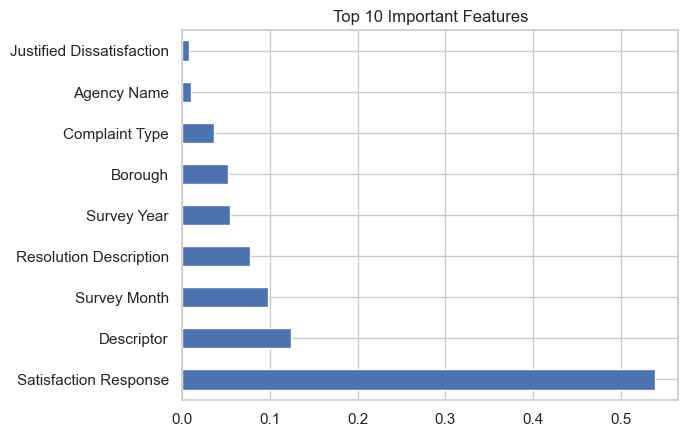

In [32]:
#feature importance
feat_importances = pd.Series(clf.feature_importances_, index=features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

### Objective 1

In [17]:
import importlib
import Satisfaction
importlib.reload(Satisfaction)

from Satisfaction import ComplaintEDA

eda = ComplaintEDA(clean_d)


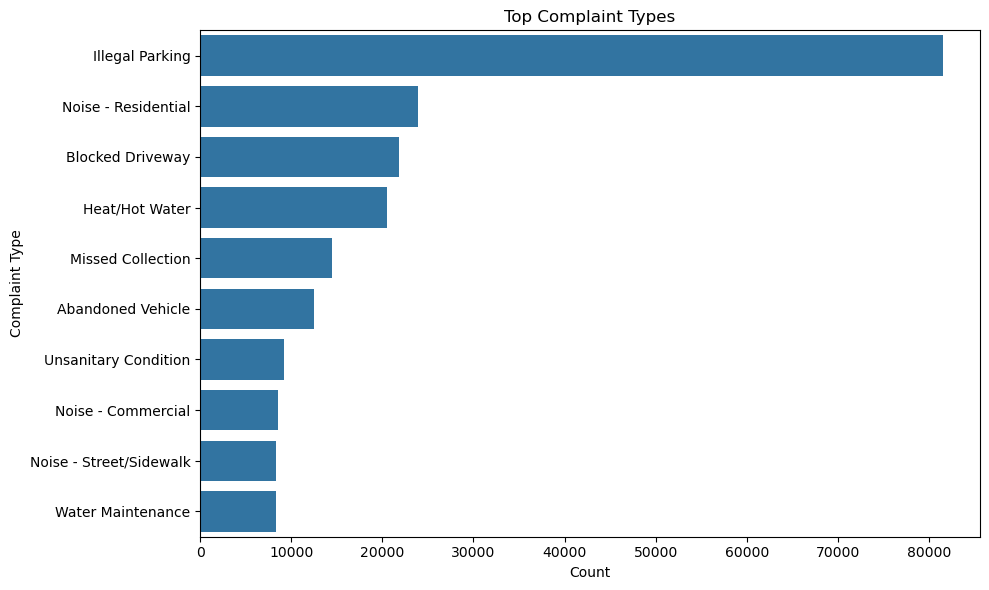

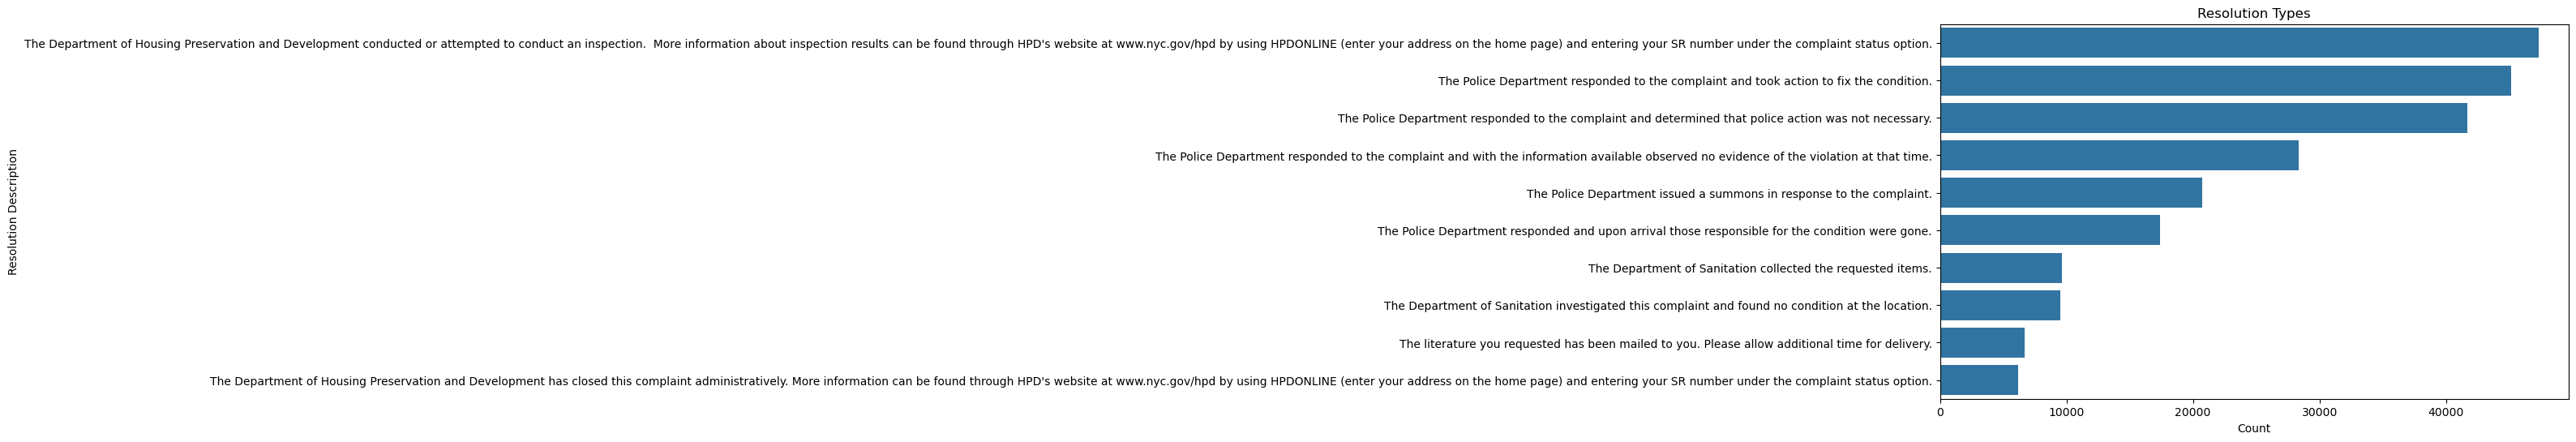

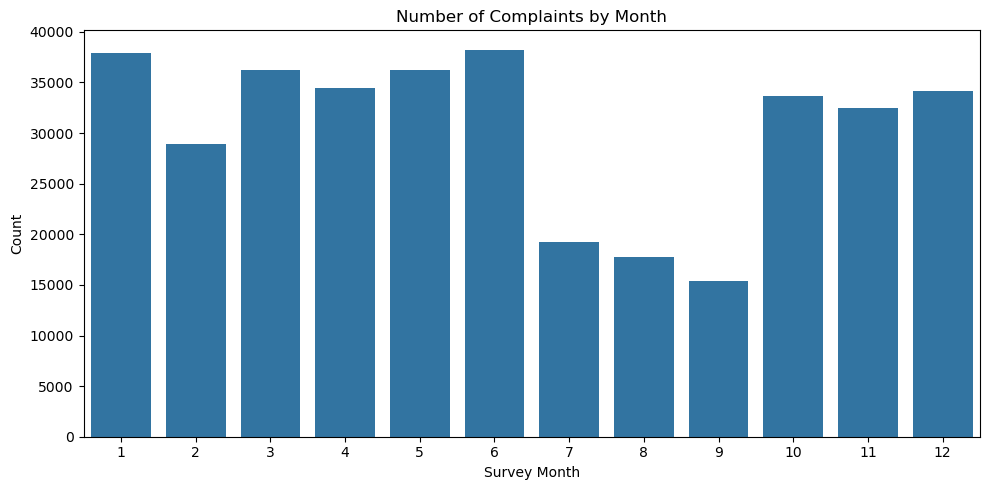

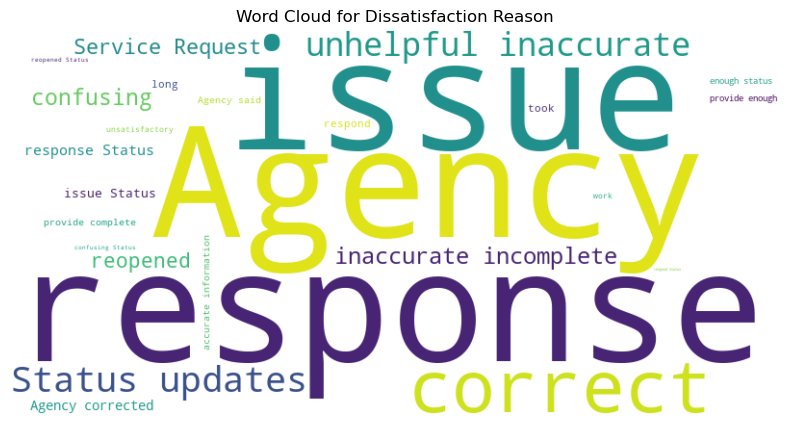

In [ ]:
# Bar plot of top 10 complaint types
eda.plot_bar('Complaint Type', title='Top Complaint Types')

# Bar plot of top resolution descriptions
eda.plot_bar('Resolution Description', title='Resolution Types', top_n=10)

# Bar plot of monthly complaints
eda.complaints_by_month()

# Word cloud of dissatisfaction reasons
eda.wordcloud_column('Dissatisfaction Reason')# Words that appear more frequently in the text are shown in larger, bolder fonts.


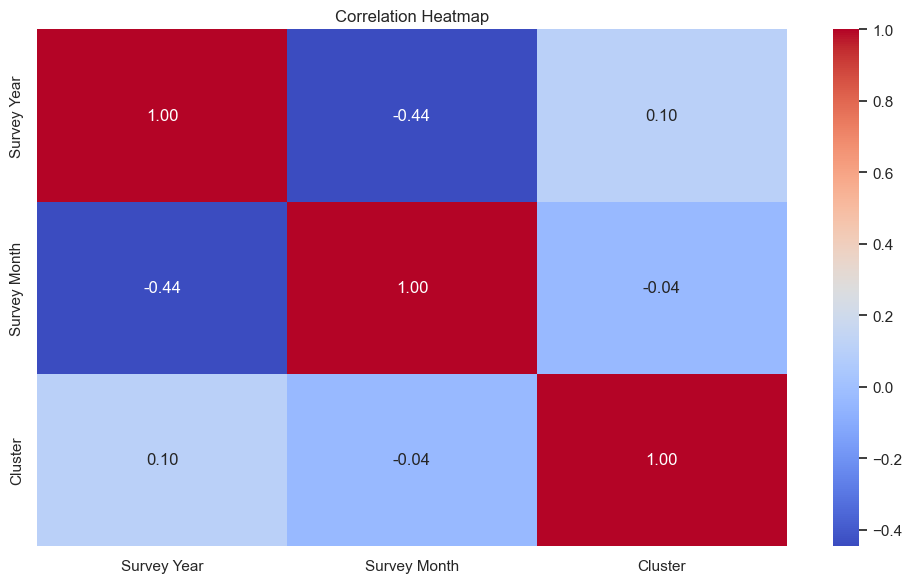

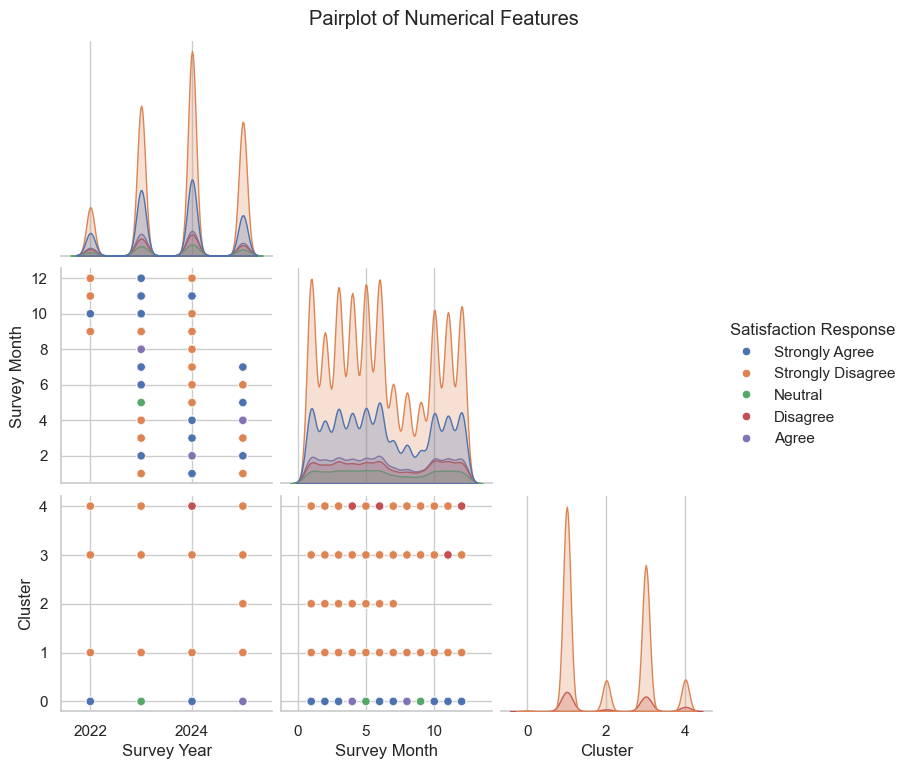

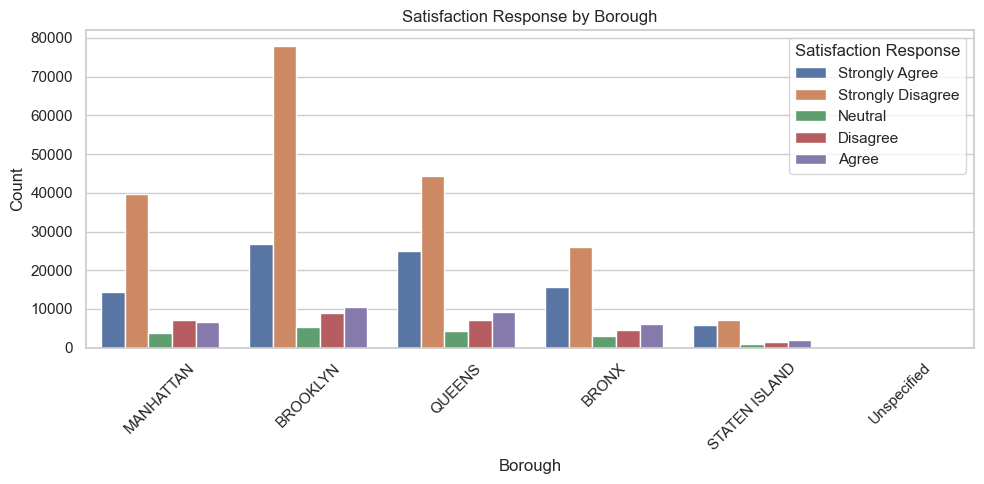

In [45]:
# Correlation heatmap
eda.plot_heatmap()

# Pairplot with Satisfaction Response as hue (if numeric columns exist)
eda.plot_pairplot(hue_column='Satisfaction Response')

# Compare satisfaction by borough
eda.satisfaction_by_borough()


### Objective 2

In [ ]:
import importlib
import Satisfaction
importlib.reload(Satisfaction)

from Satisfaction import SatisfactionVisualizer

visualizer= SatisfactionVisualizer(clean_d)

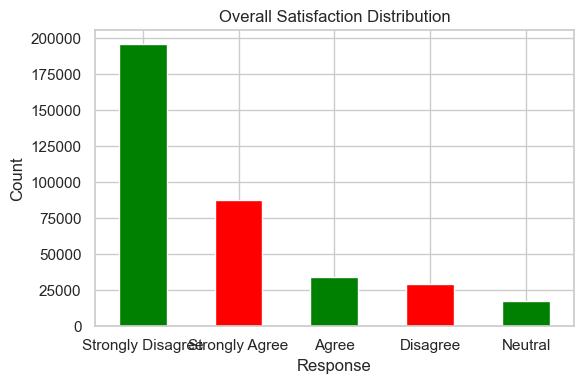

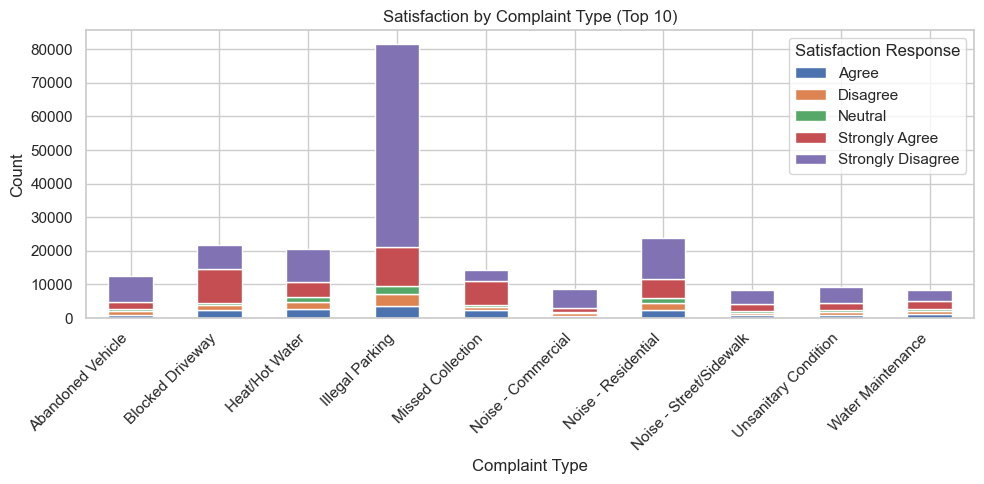

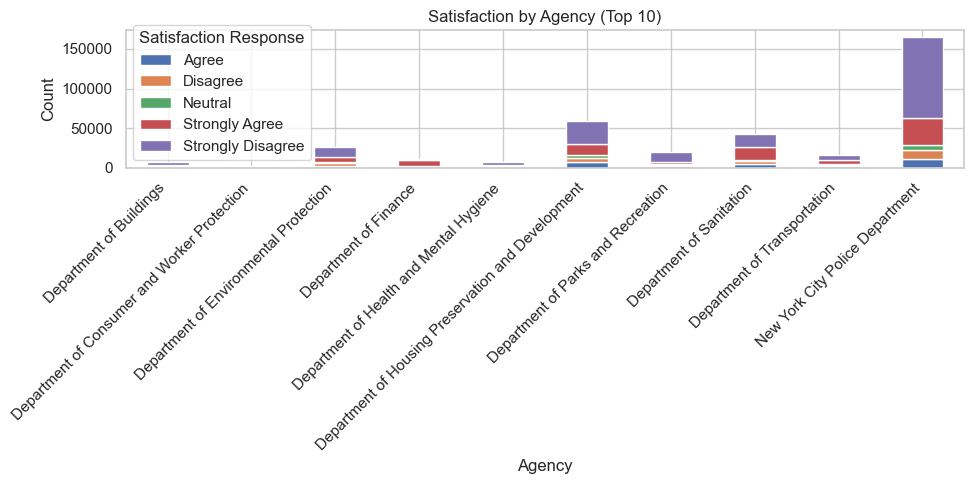

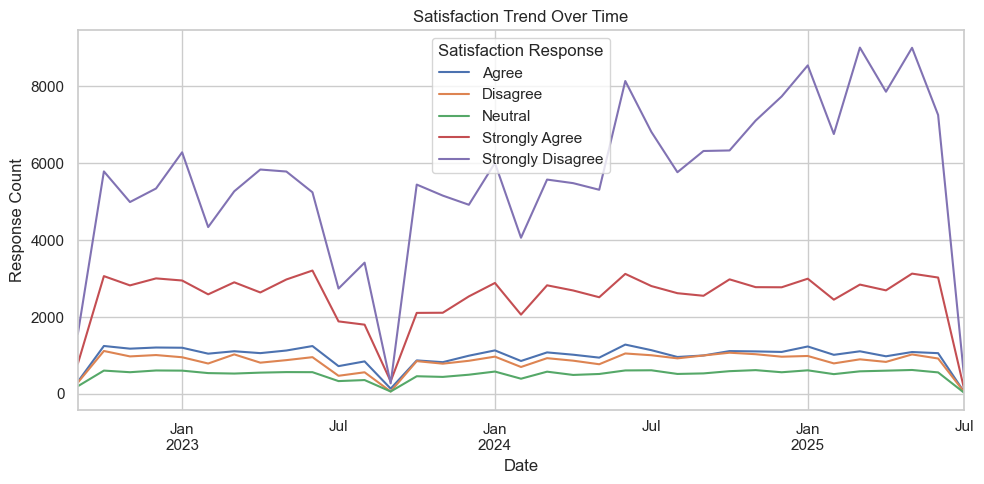

In [ ]:
# Generate visuals with error handling
for plot_func in [
	visualizer.plot_overall_satisfaction,
	visualizer.plot_satisfaction_by_complaint_type,
	visualizer.plot_satisfaction_by_agency,
	visualizer.plot_satisfaction_trend
]:
	try:
		plot_func()
	except Exception as e:
		print(f"Error in {plot_func.__name__}: {e}")

### Objective 3

##### Model preprocessing

In [18]:
# 1. Import necessary libraries
import importlib
import Satisfaction
importlib.reload(Satisfaction)

from Satisfaction import ComplaintPreprocessor

# 2. Initialize the class with your cleaned data
preprocessor = ComplaintPreprocessor(clean_d)

# 3. Encode all categorical columns except text
preprocessor.encode_categoricals()

# 4. Vectorize the detailed justification column
preprocessor.vectorize_text_column(column='Detailed Justification')

# 5. Reduce dimensions for clustering or plotting
preprocessor.reduce_dimensions(n_components=2)

# 6. Get the fully processed dataset
processed_data = preprocessor.get_processed_data()

# 7. View processed data
processed_data.head()


,Agency Name,Complaint Type,Descriptor,Borough,Resolution Description,Survey Year,Survey Month,Satisfaction Response,Dissatisfaction Reason,Justified Dissatisfaction,Detailed Justification,PC1,PC2
0,1,3,739,2,108,2022,10,3,No response,2,Delays in inspections or provision of construc...,-0.311920,-0.053759
1,1,3,739,1,108,2024,11,4,The Agency did not correct the issue.,2,Delays in inspections or provision of construc...,-0.264320,-0.047736
2,0,110,682,2,91,2024,3,3,No response,10,Lack of timely support or services for senior ...,-0.240916,-0.098643
3,1,4,507,2,123,2024,2,2,No response,2,Delays in inspections or provision of construc...,-0.311920,-0.053759
4,1,4,46,2,108,2023,10,4,"Status updates were unhelpful, inaccurate, inc...",2,Delays in inspections or provision of construc...,-0.301617,-0.072993


### Unsupervised clustering

In [19]:
# Ensure the column is clean and has no nulls
clean_d['Dissatisfaction Reason'].isnull().sum()

np.int64(0)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(clean_d['Dissatisfaction Reason'])

print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (364689, 25)


In [21]:
import numpy as np
import pandas as pd

# Get feature names
feature_names = vectorizer.get_feature_names_out()
# Sum TF-IDF values for each word
tfidf_sums = X_tfidf.sum(axis=0).A1
# Pair words with their importance
word_importance = pd.DataFrame({'word': feature_names, 'importance': tfidf_sums})
# Top 20 words
top_words = word_importance.sort_values(by='importance', ascending=False).head(20)

print(top_words)


          word     importance
16    response  140077.000000
6          did   61022.948470
4      correct   60784.719178
10       issue   60507.552860
1       agency   60322.531918
19      status    8496.186649
23     updates    8496.186649
18     service    8072.255102
13    reopened    8072.255102
14     request    8072.255102
8   incomplete    7492.831758
3    confusing    7492.831758
7   inaccurate    7492.831758
21   unhelpful    7492.831758
12     provide    2972.249926
5    corrected    2933.604621
20        took    2065.692520
11        long    2065.692520
15     respond    2065.692520
2     complete    1462.761692


In [22]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add cluster labels to your DataFrame
clean_d['Cluster'] = clusters
clean_d[['Dissatisfaction Reason', 'Cluster']].head()


,Dissatisfaction Reason,Cluster
0,No response,0
1,The Agency did not correct the issue.,1
2,No response,0
3,No response,0
4,"Status updates were unhelpful, inaccurate, inc...",4


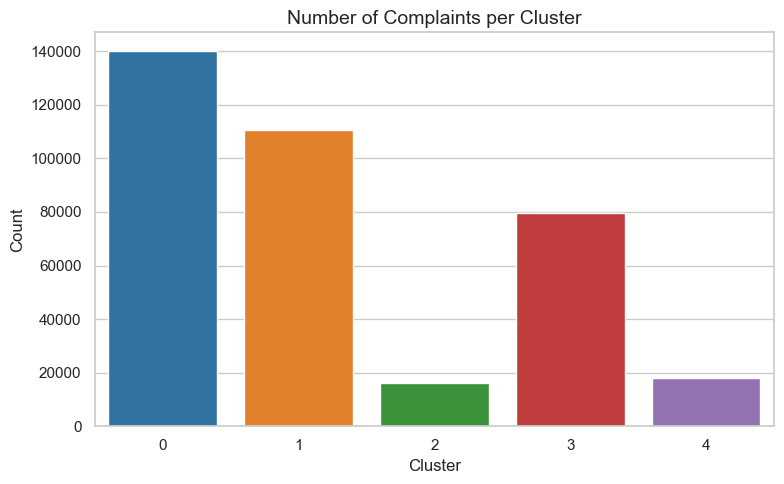

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Bar plot of number of entries per cluster
plt.figure(figsize=(8, 5))
sns.countplot(data=clean_d, x='Cluster', palette='tab10')

plt.title("Number of Complaints per Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


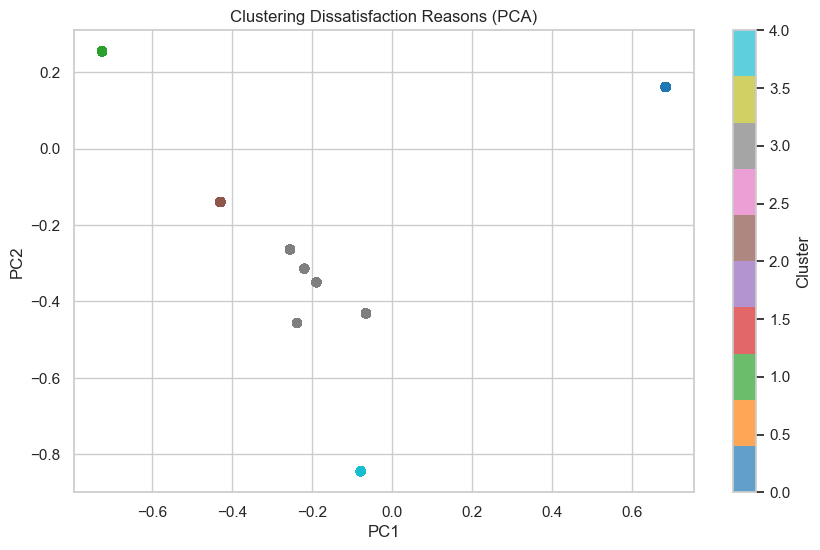

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot clusters
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("Clustering Dissatisfaction Reasons (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()


#### Supervised learning 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd


In [26]:
features = clean_d.drop(columns=['Dissatisfaction Reason', 'Detailed Justification', 'Cluster'])
target = clean_d['Cluster']


In [27]:
#encode categorical variables
le_dict = {}  # To store LabelEncoders in case you want to reverse the encoding later

for col in features.select_dtypes(include='object').columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))
    le_dict[col] = le


In [28]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [29]:

#train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [30]:
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27999
           1       0.65      0.76      0.70     22173
           2       0.54      0.62      0.58      3208
           3       0.65      0.55      0.59     15983
           4       0.20      0.09      0.12      3575

    accuracy                           0.77     72938
   macro avg       0.61      0.60      0.60     72938
weighted avg       0.76      0.77      0.76     72938



In [31]:
#lets use smote for class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# : Evaluate
y_pred = rf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     27999
           1       0.67      0.55      0.61     22173
           2       0.44      0.83      0.57      3208
           3       0.64      0.52      0.58     15983
           4       0.13      0.29      0.17      3575

    accuracy                           0.71     72938
   macro avg       0.57      0.63      0.58     72938
weighted avg       0.75      0.71      0.72     72938



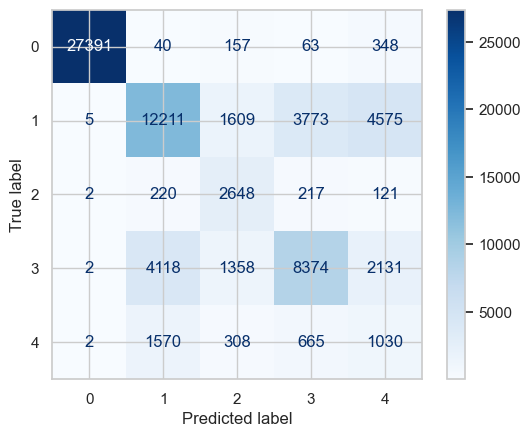

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [34]:
target.value_counts(normalize=True)#Check Class Balance


Cluster
0    0.384100
1    0.303596
3    0.218559
4    0.049774
2    0.043972
Name: proportion, dtype: float64

In [35]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_resampled, y_resampled)

y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     27999
           1       0.68      0.55      0.61     22173
           2       0.41      0.96      0.57      3208
           3       0.79      0.44      0.56     15983
           4       0.13      0.40      0.20      3575

    accuracy                           0.70     72938
   macro avg       0.60      0.67      0.59     72938
weighted avg       0.79      0.70      0.72     72938



Minority class recall improved a lot (e.g., class 2 and 4).

Precision is still low for underrepresented classes (i.e., it mislabels others as class 4 occasionally).

Macro average F1 is now 0.59 → better than before, meaning performance is more balanced across classes.

In [36]:
#use SHAP
import shap

# This assumes you've already trained your XGBClassifier as `xgb`
explainer = shap.TreeExplainer(xgb)

# Use X_test (the test set you used for evaluation)
shap_values = explainer.shap_values(X_test)


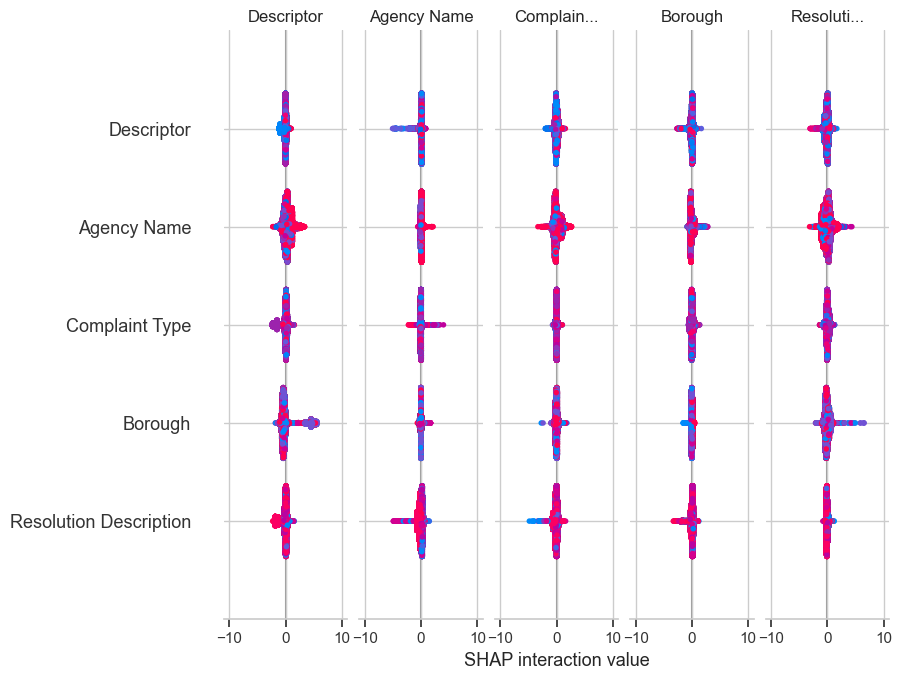

In [37]:
#summary plot
shap.summary_plot(shap_values, X_test)


Descriptor x Agency Name seems to have visible spread, meaning their combination contributes significantly in some predictions (positive or negative).

Most values are clustered around 0, indicating that for many feature pairs, the interaction effect is small or negligible.

Vertical spreads (dots going far right/left) show stronger influence for some feature combinations.

In [38]:
#import lime 
import lime
import lime.lime_tabular
import numpy as np


In [39]:
# Create a LIME explainer for tabular data
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=[str(i) for i in xgb.classes_],
    mode='classification'
)


In [40]:
i = 0  # index of the test instance
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=xgb.predict_proba
)


In [43]:
print(exp.as_list())


[('3.00 < Satisfaction Response <= 4.00', 0.11283754847071874), ('Survey Year <= 2023.00', -0.09009800197080065), ('Survey Month > 10.00', 0.0855380660085196), ('Descriptor <= 67.00', 0.020214535952142846), ('12.00 < Agency Name <= 15.00', -0.019077219382393335), ('Borough <= 1.00', -0.01812372311372819), ('533.00 < Resolution Description <= 538.00', 0.010312191631426503), ('80.00 < Complaint Type <= 99.00', 0.0035984837755370465), ('8.00 < Justified Dissatisfaction <= 12.00', -0.0017065101730172078)]


### sentiment analysis


In [47]:
clean_d.isna().sum()

Agency Name                  0
Complaint Type               0
Descriptor                   0
Borough                      0
Resolution Description       0
Survey Year                  0
Survey Month                 0
Satisfaction Response        0
Dissatisfaction Reason       0
Justified Dissatisfaction    0
Detailed Justification       0
Cluster                      0
dtype: int64

In [49]:
# Combine the two text fields
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

clean_d['Combined_Feedback'] = clean_d['Detailed Justification'] + clean_d['Dissatisfaction Reason']

# Apply sentiment scoring
clean_d['Sentiment Score'] = clean_d['Combined_Feedback'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Label the sentiment
clean_d['Sentiment Label'] = clean_d['Sentiment Score'].apply(
    lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral'
)


In [51]:
# Count with percentages
clean_d['Sentiment Label'].value_counts(normalize=True) * 100


Sentiment Label
negative    75.057378
neutral     24.056662
positive     0.885960
Name: proportion, dtype: float64

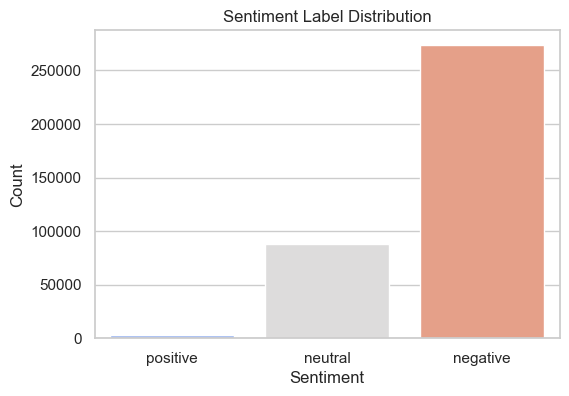

In [52]:
# Plotting the sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=clean_d, x='Sentiment Label', order=['positive', 'neutral', 'negative'], palette='coolwarm')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
#how it varies with borough
pd.crosstab(clean_d['Borough'], clean_d['Sentiment Label'], normalize='index') * 100


Sentiment Label,negative,neutral,positive
Borough,,,
BRONX,80.965644,18.865450,0.168907
BROOKLYN,77.934167,21.370949,0.694884
MANHATTAN,74.125103,23.448776,2.426121
QUEENS,71.830078,27.823324,0.346597
STATEN ISLAND,55.473903,44.346719,0.179377
Unspecified,61.187215,3.424658,35.388128


 Interpretation & Insights:
 Most Negative Sentiment:
BRONX (81%) has the highest share of negative feedback.

Indicates either service dissatisfaction or more vocal frustration from residents.

 Most Neutral:
Staten Island (44%) has the highest neutrality — possibly people reporting issues without emotional tone.

 Most Positive:
Manhattan leads in positive sentiment (2.43%) — though still low, this suggests relatively better service experience.

Unspecified (35.39%) has an unusual spike in positivity — likely due to data issues (e.g., errors, system-generated feedback, or aggregated summaries).

Recommendations:
Investigate Bronx complaints in detail
→ What are the most common issues or complaint types?

Examine “Unspecified” rows
→ They might be misclassified, missing borough info, or from aggregated text that inflates positivity.

In [54]:
#how it varies with Agency Name
pd.crosstab(clean_d['Agency Name'], clean_d['Sentiment Label'], normalize='index') * 100

Sentiment Label,negative,neutral,positive
Agency Name,,,
Department for the Aging,0.000000,0.000000,100.000000
Department of Buildings,8.296334,91.703666,0.000000
Department of Consumer and Worker Protection,100.000000,0.000000,0.000000
Department of Education,100.000000,0.000000,0.000000
Department of Environmental Protection,7.685913,92.314087,0.000000
Department of Finance,100.000000,0.000000,0.000000
Department of Health and Mental Hygiene,100.000000,0.000000,0.000000
Department of Homeless Services,0.000000,0.000000,100.000000
Department of Housing Preservation and Development,100.000000,0.000000,0.000000


Key Observations:
Highly Positive Agencies:
Dept. for the Aging and Dept. of Homeless Services: 100% positive sentiment — this is unusual and worth verifying (may indicate either great service or very low volume of records).

Economic Development Corp.: 92.7% positive — possibly reflects satisfaction with small business or development initiatives.

Mostly Neutral:
Sanitation, Transportation, Environmental Protection, Buildings: Over 90% neutral — suggesting factual reports rather than emotional feedback.

Dept. of Records: Fully neutral — expected for admin-type services.

Fully Negative Sentiment:
10+ agencies show 100% negative sentiment including:

NYC Police, Finance, Housing, Health, Education, Taxi Commission, etc.

These may reflect public frustration or controversial issues in service delivery.

Alternatively, some of these may be edge cases with small feedback volumes.

In [55]:
clean_d['Agency Name'].value_counts()


Agency Name
New York City Police Department                       165108
Department of Housing Preservation and Development     59595
Department of Sanitation                               43204
Department of Environmental Protection                 26464
Department of Parks and Recreation                     20177
Department of Transportation                           15758
Department of Finance                                  11166
Department of Buildings                                 7883
Department of Health and Mental Hygiene                 7231
Department of Consumer and Worker Protection            2558
Department of Homeless Services                         2412
Taxi and Limousine Commission                           1302
Economic Development Corporation                         867
nyc311-prd                                               448
Office of Technology and Innovation                      268
Department of Education                                  134
Unspecified 

In [ ]:
%pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Understand how people feel about something, based on their written feedback.
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment scoring
clean_d['Sentiment Score'] = clean_d['Detailed Justification'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Label sentiments
clean_d['Sentiment Label'] = clean_d['Sentiment Score'].apply(
    lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral'
)

# Check distribution
clean_d['Sentiment Label'].value_counts(normalize=True)


Note: you may need to restart the kernel to use updated packages.


Sentiment Label
negative    0.750711
neutral     0.240430
positive    0.008860
Name: proportion, dtype: float64

| Sentiment    | Proportion          | Interpretation                                                                                    |
| ------------ | ------------------- | ------------------------------------------------------------------------------------------------- |
| **negative** | `0.750711` (≈ 75%)  | Most of the textual feedback expresses dissatisfaction, frustration, anger, or disappointment. |
| **neutral**  | `0.240430` (≈ 24%)  | Some responses are factual, polite, or emotionally flat.                                       |
| **positive** | `0.008860` (≈ 0.9%) | Very few responses express satisfaction, gratitude, or happiness.                              |
